In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import export_graphviz
#from sklearn.externals.six import StringIO
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve, plot_confusion_matrix

#from category_encoders import BinaryEncoder
from IPython.display import Image
#import pydotplus
import matplotlib.pyplot as plt
%matplotlib inline
# color = sns.color_palette()


In [2]:
import seaborn as sns

In [5]:
#load data and displaying the dataset
data_w = pd.read_csv("../Resources/cleaned_loan.csv")

In [6]:
data_w.tail(10)

,loan_amnt,int_rate,installment,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,term,home_ownership,verification_status,purpose
46997,35000,6.08,1066.04,2,353000.00,1,12.09,0,1,16,0,231984,34.3,28,0,0,1,1,2
46998,20000,11.99,664.20,10,14000.00,1,37.39,0,0,21,1,10719,30.2,29,1,0,1,0,2
46999,7400,17.09,264.17,0,49900.00,1,27.20,0,1,13,0,5422,25.3,34,0,0,1,1,2
47000,10000,17.09,249.01,10,26000.00,0,16.45,0,1,6,0,13766,49.9,6,0,1,3,0,2
47001,20000,12.62,670.23,10,50000.00,0,33.94,0,2,12,0,7966,28.7,16,0,0,2,0,2
47002,27950,17.09,997.75,9,235000.00,1,25.50,0,1,20,0,118813,81.2,46,0,0,1,1,1
47003,30000,17.09,1070.93,6,88000.00,1,21.16,0,3,18,2,22979,32.9,29,1,0,3,1,2
47004,18000,14.08,615.90,0,44000.00,0,20.38,0,2,18,0,17906,23.7,21,0,0,1,1,1
47005,12000,12.62,270.71,10,89625.39,1,17.61,0,0,10,0,18601,90.3,37,0,1,1,0,2
47006,14000,13.59,475.71,2,80000.00,1,1.35,0,1,11,0,1461,4.1,21,0,0,2,1,0


In [7]:
data = data_w[['loan_amnt','int_rate','emp_length','annual_inc','loan_status','home_ownership','purpose','term']]

In [8]:
seed = 41
#make a copy of the dataset
data_lr = data.copy()

#dividing the dataset in train(70%) and test(30%)
train_set_lr, test_set_lr = train_test_split(data_lr, test_size = 0.3, random_state=seed)
X_train_lr = train_set_lr.drop(['loan_status'], axis = 1)
y_train_lr = train_set_lr['loan_status']

X_test_lr = test_set_lr.drop(['loan_status'], axis = 1)
y_test_lr = test_set_lr['loan_status']

In [9]:
#Normalizing the train and test data
scaler_lr = MinMaxScaler()
features_names = X_train_lr.columns
X_train_lr = scaler_lr.fit_transform(X_train_lr)
X_train_lr = pd.DataFrame(X_train_lr, columns = features_names)
X_test_lr = scaler_lr.transform(X_test_lr)
X_test_lr = pd.DataFrame(X_test_lr, columns = features_names)

/Users/xiaokunyu/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Percentage of people can/can not fully paid the loan')

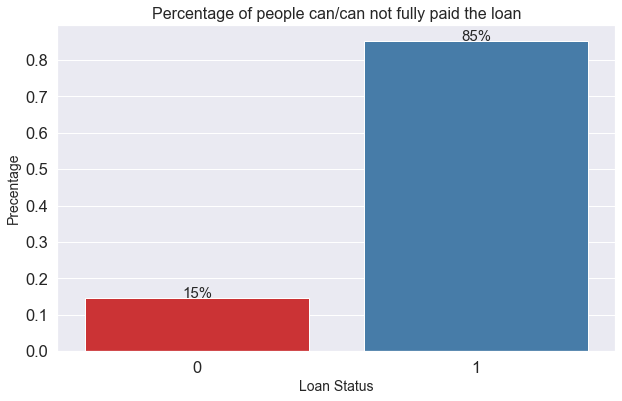

In [19]:
#find the class weight for y_train
plt.figure(figsize=(10,6))
g = sns.barplot(data_lr['loan_status'], data_lr['loan_status'], palette='Set1', estimator=lambda x: len(x) / len(data) )

#Anotating the graph
for p in g.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        g.text(x+width/2, 
               y+height, 
               '{:.0%}'.format(height), 
               horizontalalignment='center',fontsize=15)

#Setting the labels
plt.xlabel('Loan Status', fontsize=14)
plt.ylabel('Precentage', fontsize=14)
plt.title('Percentage of people can/can not fully paid the loan', fontsize=16)

In [20]:
# 0 means the people cannot fully paid the loan on time
# 1 means the people can fully paid the loan on time

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/Users/xiaokunyu/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Scoring for different class weights')

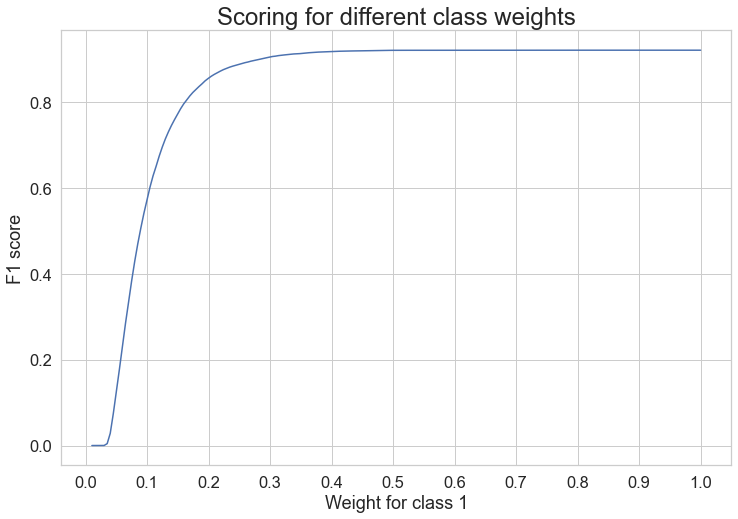

In [21]:
lr = LogisticRegression(solver='liblinear')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train_lr,y_train_lr)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [10]:
classifier = LogisticRegression(C=1.0, class_weight={0: 0.6, 1: 0.4}, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100,multi_class='ovr',n_jobs=1,penalty='l2',random_state=41,solver='liblinear',tol=0.0001,verbose=0,warm_start=False)
classifier

LogisticRegression(class_weight={0: 0.6, 1: 0.4}, multi_class='ovr', n_jobs=1,
                   random_state=41, solver='liblinear')

In [11]:
classifier.fit(X_train_lr, y_train_lr)

LogisticRegression(class_weight={0: 0.6, 1: 0.4}, multi_class='ovr', n_jobs=1,
                   random_state=41, solver='liblinear')

In [12]:
print(f"Training Data Score: {classifier.score(X_train_lr, y_train_lr)}")
print(f"Testing Data Score: {classifier.score(X_test_lr, y_test_lr)}")

Training Data Score: 0.848863360077802
Testing Data Score: 0.8477628873289371


The f1 score for the testing data: 0.9167280766396464


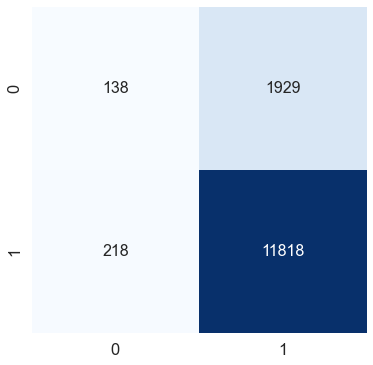

In [13]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Predicting on the test data
pred_test = classifier.predict(X_test_lr)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test_lr, pred_test)
print('The f1 score for the testing data:', f1_test)

# Function to create a confusion matrix 
def conf_matrix(y_test_lr, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test_lr, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    
#Calling function 
conf_matrix(y_test_lr, pred_test)

In [14]:
#print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_lr,pred_test))

              precision    recall  f1-score   support

           0       0.39      0.07      0.11      2067
           1       0.86      0.98      0.92     12036

    accuracy                           0.85     14103
   macro avg       0.62      0.52      0.52     14103
weighted avg       0.79      0.85      0.80     14103



In [39]:
#test an extreme situation
#feature 'loan_amnt','int_rate','emp_length','annual_inc','home_ownership','purpose','term'

user_input=[40000,31,0,33,0,12,0]
result = classifier.predict([user_input])[0]
result

0

In [17]:
import pickle
pickle.dump(classifier, open('lrmodel.pkl','wb'))